In [1]:
# for use in tutorial and development; do not include this `sys.path` change in production:
import sys ; sys.path.insert(0, "../")

# Explain PyTextRank: the algorithm

Let's look at the *TextRank* algorithm used to build a graph from a raw text, and then from that extract the top-ranked phrases. This work is based on 
["TextRank: Bringing Order into Text"](http://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf),
Rada Mihalcea, Paul Tarau, _Empirical Methods in Natural Language Processing_ (2004).

---
First we perform some basic housekeeping for Jupyter, then load `spaCy` with a language model for English ...

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import spacy
nlp = spacy.load("en_core_web_sm")

Now, to get started, we'll create some text to use.

In [4]:
#text = "When Ada was twelve years old, this future 'Lady Fairy', as Charles Babbage affectionately called her, decided she wanted to fly. Ada Byron went about the project methodically, thoughtfully, with imagination and passion. Her first step, in February 1828, was to construct wings. She investigated different material and sizes. She considered various materials for the wings: paper, oilsilk, wires, and feathers. She examined the anatomy of birds to determine the right proportion between the wings and the body. She decided to write a book, Flyology, illustrating, with plates, some of her findings. She decided what equipment she would need; for example, a compass, to 'cut across the country by the most direct road', so that she could surmount mountains, rivers, and valleys. Her final step was to integrate steam with the 'art of flying."

text = "Compatibility of systems of linear constraints over the set of natural numbers. Criteria of compatibility of a system of linear Diophantine equations, strict inequations, and nonstrict inequations are considered. Upper bounds for components of a minimal set of solutions and algorithms of construction of minimal generating sets of solutions for all types of systems are given. These criteria and the corresponding algorithms for constructing a minimal supporting set of solutions can be used in solving all the considered types systems and systems of mixed types."

doc = nlp(text)

How many sentences are in the parsed document and where are their boundaries?

In [5]:
from icecream import ic

for sent in doc.sents:
    ic(sent.start, sent.end)

ic| sent.start: 0, sent.end: 13
ic| sent.start: 13, sent.end: 33
ic| sent.start: 33, sent.end: 61
ic| sent.start: 61, sent.end: 91


What are the raw _noun chunks_ in the parsed document?

In [6]:
for chunk in doc.noun_chunks:
    ic(chunk.text)

ic| chunk.text: 'Compatibility'
ic| chunk.text: 'systems'
ic| chunk.text: 'linear constraints'
ic| chunk.text: 'the set'
ic| chunk.text: 'natural numbers'
ic| chunk.text: 'Criteria'
ic| chunk.text: 'compatibility'
ic| chunk.text: 'a system'
ic| chunk.text: 'linear Diophantine equations'
ic| chunk.text: 'strict inequations'
ic| chunk.text: 'nonstrict inequations'
ic| chunk.text: 'Upper bounds'
ic| chunk.text: 'components'
ic| chunk.text: 'a minimal set'
ic| chunk.text: 'solutions'
ic| chunk.text: 'algorithms'
ic| chunk.text: 'construction'
ic| chunk.text: 'minimal generating sets'
ic| chunk.text: 'solutions'
ic| chunk.text: 'all types'
ic| chunk.text: 'systems'
ic| chunk.text: 'These criteria'
ic| chunk.text: 'the corresponding algorithms'
ic| chunk.text: 'a minimal supporting set'
ic| chunk.text: 'solutions'
ic| chunk.text: 'all the considered types systems'
ic| chunk.text: 'systems'
ic| chunk.text: 'mixed types'


Also, does `spaCy` detect any _named entities_?

In [7]:
for ent in doc.ents:
    ic(ent.text, ent.label_, ent.start, ent.end)

ic| ent.text: 'Diophantine'
    ent.label_: 'GPE'
    ent.start: 21
    ent.end: 22


Given those details about the parsed document, next we use [NetworkX](https://networkx.github.io/) to manage an in-memory graph...

In [8]:
import networkx as nx

def increment_edge (graph, node0, node1):
    ic(node0, node1)
    
    if graph.has_edge(node0, node1):
        graph[node0][node1]["weight"] += 1.0
    else:
        graph.add_edge(node0, node1, weight=1.0)

Then construct a graph, sentence by sentence, based on the [spaCy part-of-speech tags](https://spacy.io/api/annotation#pos-en) tags:

In [9]:
POS_KEPT = ["ADJ", "NOUN", "PROPN", "VERB"]

def link_sentence (doc, sent, lemma_graph, seen_lemma):
    visited_tokens = []
    visited_nodes = []

    for i in range(sent.start, sent.end):
        token = doc[i]

        if token.pos_ in POS_KEPT:
            key = (token.lemma_, token.pos_)

            if key not in seen_lemma:
                seen_lemma[key] = set([token.i])
            else:
                seen_lemma[key].add(token.i)

            node_id = list(seen_lemma.keys()).index(key)

            if not node_id in lemma_graph:
                lemma_graph.add_node(node_id)

            ic(visited_tokens, visited_nodes)
            ic(list(range(len(visited_tokens) - 1, -1, -1)))
            
            for prev_token in range(len(visited_tokens) - 1, -1, -1):
                ic(prev_token, (token.i - visited_tokens[prev_token]))
                
                if (token.i - visited_tokens[prev_token]) <= 3:
                    increment_edge(lemma_graph, node_id, visited_nodes[prev_token])
                else:
                    break

            ic(token.i, token.text, token.lemma_, token.pos_, visited_tokens, visited_nodes)

            visited_tokens.append(token.i)
            visited_nodes.append(node_id)

Now iterate through the sentences to construct the lemma graph...

In [10]:
lemma_graph = nx.Graph()
seen_lemma = {}

for sent in doc.sents:
    link_sentence(doc, sent, lemma_graph, seen_lemma)
    #break # only test one sentence

ic| visited_tokens: [], visited_nodes: []
ic| list(range(len(visited_tokens) - 1, -1, -1)): []
ic| token.i: 0
    token.text: 'Compatibility'
    token.lemma_: 'compatibility'
    token.pos_: 'NOUN'
    visited_tokens: []
    visited_nodes: []
ic| visited_tokens: [0], visited_nodes: [0]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [0]
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 2
ic| node0: 1, node1: 0
ic| token.i: 2
    token.text: 'systems'
    token.lemma_: 'system'
    token.pos_: 'NOUN'
    visited_tokens: [0]
    visited_nodes: [0]
ic| visited_tokens: [0, 2], visited_nodes: [0, 1]
ic| list(range(len(visited_tokens) - 1, -1, -1)): [1, 0]
ic| prev_token: 1, token.i - visited_tokens[prev_token]: 2
ic| node0: 2, node1: 1
ic| prev_token: 0, token.i - visited_tokens[prev_token]: 4
ic| token.i: 4
    token.text: 'linear'
    token.lemma_: 'linear'
    token.pos_: 'ADJ'
    visited_tokens: [0, 2]
    visited_nodes: [0, 1]
ic| visited_tokens: [0, 2, 4], visited_nodes: [0

In [11]:
ic(seen_lemma)

ic| seen_lemma: {('Diophantine', 'PROPN'): {21},
                 ('Upper', 'PROPN'): {33},
                 ('algorithm', 'NOUN'): {66, 44},
                 ('bound', 'NOUN'): {34},
                 ('compatibility', 'NOUN'): {0, 15},
                 ('component', 'NOUN'): {36},
                 ('consider', 'VERB'): {82, 31},
                 ('constraint', 'NOUN'): {5},
                 ('construct', 'VERB'): {68},
                 ('construction', 'NOUN'): {46},
                 ('correspond', 'VERB'): {65},
                 ('criterion', 'NOUN'): {13, 62},
                 ('equation', 'NOUN'): {22},
                 ('generating', 'NOUN'): {49},
                 ('give', 'VERB'): {59},
                 ('inequation', 'NOUN'): {25, 29},
                 ('linear', 'ADJ'): {4, 20},
                 ('minimal', 'ADJ'): {48, 70, 39},
                 ('mixed', 'ADJ'): {88},
                 ('natural', 'ADJ'): {10},
                 ('nonstrict', 'ADJ'): {28},
                 ('nu

{('compatibility', 'NOUN'): {0, 15},
 ('system', 'NOUN'): {2, 18, 57, 84, 86},
 ('linear', 'ADJ'): {4, 20},
 ('constraint', 'NOUN'): {5},
 ('set', 'NOUN'): {8, 40, 50, 72},
 ('natural', 'ADJ'): {10},
 ('number', 'NOUN'): {11},
 ('criterion', 'NOUN'): {13, 62},
 ('Diophantine', 'PROPN'): {21},
 ('equation', 'NOUN'): {22},
 ('strict', 'ADJ'): {24},
 ('inequation', 'NOUN'): {25, 29},
 ('nonstrict', 'ADJ'): {28},
 ('consider', 'VERB'): {31, 82},
 ('Upper', 'PROPN'): {33},
 ('bound', 'NOUN'): {34},
 ('component', 'NOUN'): {36},
 ('minimal', 'ADJ'): {39, 48, 70},
 ('solution', 'NOUN'): {42, 52, 74},
 ('algorithm', 'NOUN'): {44, 66},
 ('construction', 'NOUN'): {46},
 ('generating', 'NOUN'): {49},
 ('type', 'NOUN'): {55, 83, 89},
 ('give', 'VERB'): {59},
 ('correspond', 'VERB'): {65},
 ('construct', 'VERB'): {68},
 ('support', 'VERB'): {71},
 ('use', 'VERB'): {77},
 ('solve', 'VERB'): {79},
 ('mixed', 'ADJ'): {88}}

Let's visualize the lemma graph, and for that first we need to collect a dictionary of the labels.

In [12]:
labels = {}
keys = list(seen_lemma.keys())

for i in range(len(seen_lemma)):
    labels[i] = keys[i][0].lower()

labels

{0: 'compatibility',
 1: 'system',
 2: 'linear',
 3: 'constraint',
 4: 'set',
 5: 'natural',
 6: 'number',
 7: 'criterion',
 8: 'diophantine',
 9: 'equation',
 10: 'strict',
 11: 'inequation',
 12: 'nonstrict',
 13: 'consider',
 14: 'upper',
 15: 'bound',
 16: 'component',
 17: 'minimal',
 18: 'solution',
 19: 'algorithm',
 20: 'construction',
 21: 'generating',
 22: 'type',
 23: 'give',
 24: 'correspond',
 25: 'construct',
 26: 'support',
 27: 'use',
 28: 'solve',
 29: 'mixed'}

Then use `matplotlib` to visualize the lemma graph:

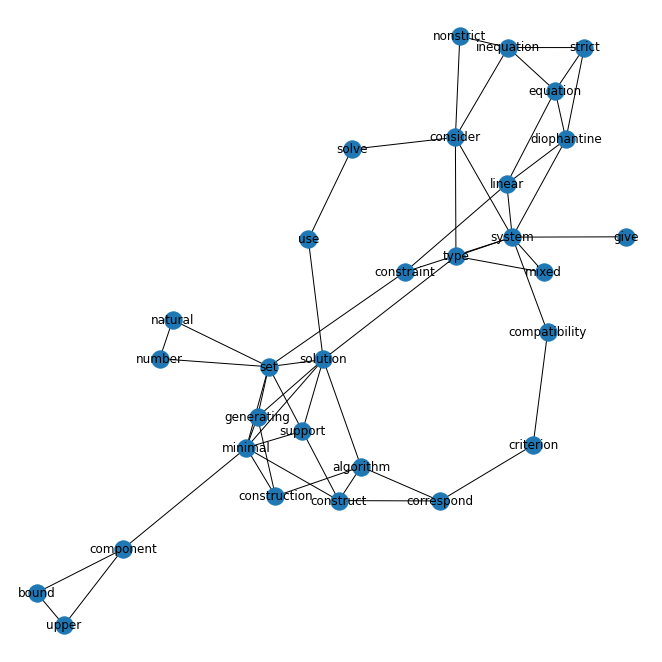

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 9))
pos = nx.spring_layout(lemma_graph)

nx.draw(lemma_graph, pos=pos, with_labels=False, font_weight="bold")
nx.draw_networkx_labels(lemma_graph, pos, labels);

Now to run the algorithm, we use `PageRank` – a form of
[*eigenvector centrality*](https://derwen.ai/docs/ptr/glossary/#eigenvector-centrality)
– to calculate ranks for each of the nodes in the lemma graph.

In [14]:
ranks = nx.pagerank(lemma_graph)
ranks

{0: 0.025190055141357165,
 1: 0.09709174565608479,
 2: 0.03658656272138432,
 3: 0.022947339381092696,
 4: 0.07548767636963792,
 5: 0.01884004785394172,
 6: 0.01884004785394172,
 7: 0.019767433918161055,
 8: 0.03093250736456608,
 9: 0.031636552282656216,
 10: 0.0250439175297852,
 11: 0.03969617593153302,
 12: 0.02513276636673567,
 13: 0.0390375393827704,
 14: 0.02428614673389346,
 15: 0.02428614673389346,
 16: 0.031629446298645975,
 17: 0.06334806476862227,
 18: 0.061826419749828485,
 19: 0.03201021345587308,
 20: 0.02404712231242087,
 21: 0.029468555366439973,
 22: 0.04816979699201436,
 23: 0.010894627731045426,
 24: 0.026930354700088012,
 25: 0.03165915652710971,
 26: 0.029382686223731833,
 27: 0.019263849959229938,
 28: 0.01982332786706688,
 29: 0.016743716826448173}

In [15]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    ic(node_id, rank, labels[node_id])

ic| node_id: 1, rank: 0.09709174565608479, labels[node_id]: 'system'
ic| node_id: 4, rank: 0.07548767636963792, labels[node_id]: 'set'
ic| node_id: 17, rank: 0.06334806476862227, labels[node_id]: 'minimal'
ic| node_id: 18
    rank: 0.061826419749828485
    labels[node_id]: 'solution'
ic| node_id: 22, rank: 0.04816979699201436, labels[node_id]: 'type'
ic| node_id: 11
    rank: 0.03969617593153302
    labels[node_id]: 'inequation'
ic| node_id: 13, rank: 0.0390375393827704, labels[node_id]: 'consider'
ic| node_id: 2, rank: 0.03658656272138432, labels[node_id]: 'linear'
ic| node_id: 19
    rank: 0.03201021345587308
    labels[node_id]: 'algorithm'
ic| node_id: 25
    rank: 0.03165915652710971
    labels[node_id]: 'construct'
ic| node_id: 9
    rank: 0.031636552282656216
    labels[node_id]: 'equation'
ic| node_id: 16
    rank: 0.031629446298645975
    labels[node_id]: 'component'
ic| node_id: 8
    rank: 0.03093250736456608
    labels[node_id]: 'diophantine'
ic| node_id: 21
    rank: 0.029

Define a function to collect the top-ranked phrases from the lemma graph.

In [16]:
import math

def collect_phrases (chunk, phrases, counts):
    chunk_len = chunk.end - chunk.start
    sq_sum_rank = 0.0
    non_lemma = 0
    compound_key = set([])

    for i in range(chunk.start, chunk.end):
        token = doc[i]
        key = (token.lemma_, token.pos_)
        
        if key in seen_lemma:
            node_id = list(seen_lemma.keys()).index(key)
            rank = ranks[node_id]
            sq_sum_rank += rank
            compound_key.add(key)
        
            ic(token.lemma_, token.pos_, node_id, rank)
        else:
            non_lemma += 1
    
    # although the noun chunking is greedy, we discount the ranks using a
    # point estimate based on the number of non-lemma tokens within a phrase
    non_lemma_discount = chunk_len / (chunk_len + (2.0 * non_lemma) + 1.0)

    # use root mean square (RMS) to normalize the contributions of all the tokens
    phrase_rank = math.sqrt(sq_sum_rank / (chunk_len + non_lemma))
    phrase_rank *= non_lemma_discount

    # remove spurious punctuation
    phrase = chunk.text.lower().replace("'", "")

    # create a unique key for the the phrase based on its lemma components
    compound_key = tuple(sorted(list(compound_key)))
    
    if not compound_key in phrases:
        phrases[compound_key] = set([ (phrase, phrase_rank) ])
        counts[compound_key] = 1
    else:
        phrases[compound_key].add( (phrase, phrase_rank) )
        counts[compound_key] += 1

    ic(phrase_rank, chunk.text, chunk.start, chunk.end, chunk_len, counts[compound_key])

Collect the top-ranked phrases based on both the noun chunks and the named entities...

In [17]:
phrases = {}
counts = {}

for chunk in doc.noun_chunks:
    collect_phrases(chunk, phrases, counts)

ic| token.lemma_: 'compatibility'
    token.pos_: 'NOUN'
    node_id: 0
    rank: 0.025190055141357165
ic| phrase_rank: 0.07935687610622845
    chunk.text: 'Compatibility'
    chunk.start: 0
    chunk.end: 1
    chunk_len: 1
    counts[compound_key]: 1
ic| token.lemma_: 'system'
    token.pos_: 'NOUN'
    node_id: 1
    rank: 0.09709174565608479
ic| phrase_rank: 0.15579774200552843
    chunk.text: 'systems'
    chunk.start: 2
    chunk.end: 3
    chunk_len: 1
    counts[compound_key]: 1
ic| token.lemma_: 'linear'
    token.pos_: 'ADJ'
    node_id: 2
    rank: 0.03658656272138432
ic| token.lemma_: 'constraint'
    token.pos_: 'NOUN'
    node_id: 3
    rank: 0.022947339381092696
ic| phrase_rank: 0.11502067650110856
    chunk.text: 'linear constraints'
    chunk.start: 4
    chunk.end: 6
    chunk_len: 2
    counts[compound_key]: 1
ic| token.lemma_: 'set'
    token.pos_: 'NOUN'
    node_id: 4
    rank: 0.07548767636963792
ic| phrase_rank: 0.06345084244027568
    chunk.text: 'the set'
    

In [18]:
for ent in doc.ents:
    collect_phrases(ent, phrases, counts)

ic| token.lemma_: 'Diophantine'
    token.pos_: 'PROPN'
    node_id: 8
    rank: 0.03093250736456608
ic| phrase_rank: 0.08793819898736567
    chunk.text: 'Diophantine'
    chunk.start: 21
    chunk.end: 22
    chunk_len: 1
    counts[compound_key]: 1


Since noun chunks can be expressed in different ways (e.g., they may have articles or prepositions), we need to find a minimum span for each phrase based on combinations of lemmas...

In [19]:
import operator

min_phrases = {}

for compound_key, rank_tuples in phrases.items():
    l = list(rank_tuples)
    l.sort(key=operator.itemgetter(1), reverse=True)
    
    phrase, rank = l[0]
    count = counts[compound_key]
    
    min_phrases[phrase] = (rank, count)

Then let's examine the results of TextRank...

In [20]:
for phrase, (rank, count) in sorted(min_phrases.items(), key=lambda x: x[1][0], reverse=True):
    ic(phrase, count, rank)

ic| phrase: 'minimal generating sets'
    count: 1
    rank: 0.17764305670256655
ic| phrase: 'systems', count: 4, rank: 0.15579774200552843
ic| phrase: 'linear diophantine equations'
    count: 1
    rank: 0.13635130800294415
ic| phrase: 'solutions', count: 3, rank: 0.12432459506251015
ic| phrase: 'mixed types', count: 1, rank: 0.12010505939797736
ic| phrase: 'nonstrict inequations'
    count: 1
    rank: 0.12002679543267614
ic| phrase: 'strict inequations', count: 1, rank: 0.11994451815672316
ic| phrase: 'linear constraints', count: 1, rank: 0.11502067650110856
ic| phrase: 'a minimal supporting set'
    count: 1
    rank: 0.10481265770639074
ic| phrase: 'upper bounds', count: 1, rank: 0.10389342131646997
ic| phrase: 'a minimal set', count: 1, rank: 0.09315167105930662
ic| phrase: 'natural numbers', count: 1, rank: 0.09150603587606598
ic| phrase: 'algorithms', count: 1, rank: 0.08945699169974514
ic| phrase: 'components', count: 1, rank: 0.08892334662315343
ic| phrase: 'diophantine', co

Just for kicks, compare with raw results of the non-chunked lemma nodes...

In [21]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    ic(labels[node_id], rank)

ic| labels[node_id]: 'system', rank: 0.09709174565608479
ic| labels[node_id]: 'set', rank: 0.07548767636963792
ic| labels[node_id]: 'minimal', rank: 0.06334806476862227
ic| labels[node_id]: 'solution', rank: 0.061826419749828485
ic| labels[node_id]: 'type', rank: 0.04816979699201436
ic| labels[node_id]: 'inequation', rank: 0.03969617593153302
ic| labels[node_id]: 'consider', rank: 0.0390375393827704
ic| labels[node_id]: 'linear', rank: 0.03658656272138432
ic| labels[node_id]: 'algorithm', rank: 0.03201021345587308
ic| labels[node_id]: 'construct', rank: 0.03165915652710971
ic| labels[node_id]: 'equation', rank: 0.031636552282656216
ic| labels[node_id]: 'component', rank: 0.031629446298645975
ic| labels[node_id]: 'diophantine', rank: 0.03093250736456608
ic| labels[node_id]: 'generating', rank: 0.029468555366439973
ic| labels[node_id]: 'support', rank: 0.029382686223731833
ic| labels[node_id]: 'correspond', rank: 0.026930354700088012
ic| labels[node_id]: 'compatibility', rank: 0.02519005